## Reversionspendel

In [232]:
%pylab qt5
import os

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 7)

import scipy.optimize

numpy.set_printoptions(linewidth=100)

Populating the interactive namespace from numpy and matplotlib


In [233]:
# lade Daten
A = loadtxt('./versuch1.csv', delimiter=',', skiprows=1,
           converters=dict(zip([2, 4], [lambda s: NaN if s==b'' else float(s)]*2)))
n, T1, dev_T1, T2, dev_T2 = transpose(A)

In [235]:
# schätzt Standardabweichung ab und berücksichtig mehrfachmessungen
mult = [[2.241, 2.250, 2.258, 2.258], [1.908, 1.923], [1.805, 1.806, 1.801, 1.804]]
var = 0
for l in mult:
    l = array(l)
    m = mean(l)
    q = (l - m)/m
    print(q)
    var += sum(q**2)
devq = sqrt(var)
devq, devq * 1.8

[-0.00477406 -0.00077717  0.00277562  0.00277562]
[-0.00391543  0.00391543]
[ 0.00055432  0.00110865 -0.00166297  0.        ]


(0.008588759713942287, 0.015459767485096117)

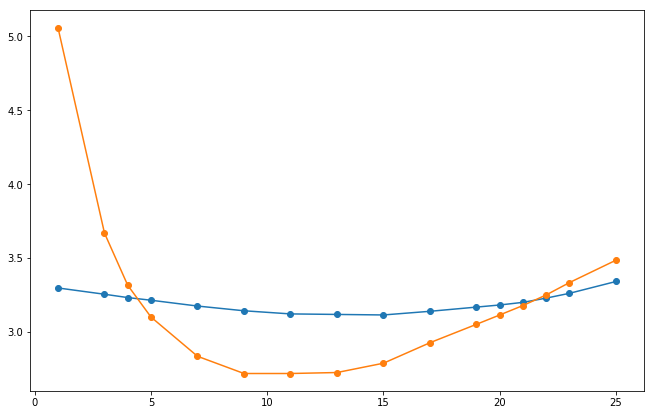

In [236]:
plt.plot(n, transpose([T1**2, T2**2]), 'o-')

In [281]:
def fun3(x, a, b, c, x0):
    return (a + b * (x - x0)**2) / (x - x0 + c)

def jac3(x, a, b, c, x0):
    return transpose([1/(c + x - x0),
                  ((x - x0)**2/(c + x - x0)),
                  (a + b*(x - x0)**2)/(c + x - x0)**2,
                  -b + (a + b*c**2)/(c + x - x0)**2])

def dx(x, a, b, c, x0):
    return b - (a + b*c**2)/(x - x0 + c)**2

In [282]:
# wird jetzt doch nicht mehr gebraucht, nachdem ich sinnvolle Startwerde für p1 gefunden habe...
# aber ich lass das mal drin weil die Methode mal anders vielleicht praktisch sein könnte
def fit_curve(f, x, y, p0=None, maxfev=3000, fixed=None, jac=None, **kwargs):
    nargs = f.__code__.co_argcount - 1
    if fixed == None:
        fixed = [None]*nargs
    if p0 == None:
        p0 = [1]*nargs
    assert len(fixed) == len(p0) == nargs, (nargs, fixed, p0)
    p0it = iter(p0)
    p0_ = array([p0[i] for i in range(nargs) if fixed[i] is None])
    
    ff = lambda *args: f(*(arg for i, arg in enumerate(args) if i==0 or not fixed[i-1]))
    def ff(*args):
        it = iter(args)
        return f(next(it), *(next(it) if val is None else val for val in fixed))
    
    def jac_(*args):
        it = iter(args)
        grad = jac(next(it), *(next(it) if val is None else val for val in fixed))
        return array([[rad[i] for i in range(nargs) if fixed[i] is None]])
    
    popt, pcov = scipy.optimize.curve_fit(ff, x, y, p0=p0_, maxfev=maxfev, **kwargs)
    pit = iter(popt)
    return array([next(pit) if val is None else val for val in fixed]), pcov

Wir fitten nun unsere Theoriekurve in die Daten. Es ist sehr wichtig dabei gute startparameter zu wählen. Insbesondere müssen `a` und `b` das korrekte Vorzeichen haben (erschließt sich aus der Geometrie des Pendels). Auserdem muss die Differenz `x0 - c` auf der richtigen Seite des Intervalls $[1, 25]$ (und auf keinen Fall innerhalb) liegen.

(array([-1.59083765e+02, -8.40740484e-02, -4.17226275e+01,  3.22091991e+01]),
 array([3.44111257e+01, 1.35566488e-02, 1.25280784e+01, 3.11812845e+00]))

(array([18.67168946,  0.10381908,  0.41502097, -2.53183791]),
 array([0.64423153, 0.00197616, 0.37579875, 0.2857074 ]))

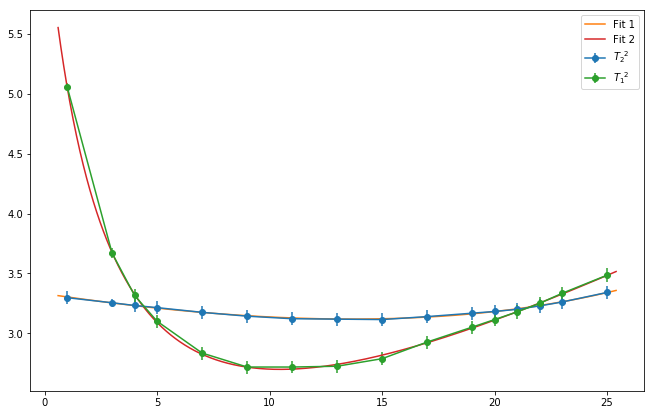

In [349]:
fit = fun3
sc = 1 # damit überprüfen wir ob die Numerik passt

p01=array([sc*-160, sc*-0.085, -42, 32])
p02 = [18, 0.1, .5, -2.5]

mess1 = array([1, 1/sqrt(4)] + [1]*14)
popt1, pcov1 = scipy.optimize.curve_fit(fit, n, sc*T1**2, p0=p01, sigma=2*T1**2*devq*mess1,
                                        jac=jac3, maxfev=3000)

popt1, sqrt(diag(pcov1))
x = linspace(min(n) - .4, max(n) + .4, 1000)
_ = plt.errorbar(n, sc*T1**2, yerr=2*T1**2*devq*mess1, fmt='o-')
_ = plt.plot(x, vectorize(fit)(x, *popt1))


mess2 = array([1/sqrt(4), 1/sqrt(2)] + [1]*14)
popt2, pcov2 = scipy.optimize.curve_fit(fit, n, T2**2, p0=p02, sigma=2*T2**2*devq*mess2, jac=jac3)

popt2, sqrt(diag(pcov2))
_ = plt.errorbar(n, T2**2, yerr=2*T1**2*devq*mess2, fmt='o-')
_ = plt.plot(x, vectorize(fit)(x, *popt2))

plt.legend(['Fit 1', 'Fit 2', '${T_2}^2$', '${T_1}^2$'])

Die Konditionen der involvierten Matrizen sind zwar alles andere als optimal, aber `scipy.optimize.curve_fit` scheint nur mit `float64` zu arbeiten

In [324]:
cond(pcov1)
cond(pcov2)

83905599066.55948

15801826.246751318

In [285]:
savetxt('werte1.csv', transpose([n, T1, T1*devq*mess1, T2, T2*devq*mess2]),
        header='n,T1,err_T1,T2,err_T2', comments='',  delimiter=',')

Wir Berechnen die Schnittpunkte der beiden Graphen numerisch (Newton-Verfahren)

In [271]:
z1 = scipy.optimize.newton(lambda x: fun3(x, *popt1) - fun3(x, *popt2), 4.4, fprime=lambda x: dx(x, *popt1) - dx(x, *popt2))
z2 = scipy.optimize.newton(lambda x: fun3(x, *popt1) - fun3(x, *popt2), 21.5, fprime=lambda x: dx(x, *popt1) - dx(x, *popt2))
print(z1, z2)

4.3964218634732415 21.564183211740385


$y = T^2$ 

In [353]:
y1 = fun3(z1, *popt1)
y2 = fun3(z2, *popt1)
print(y1, y1, y1 - y2)

3.2230961257381483 3.2230961257381483 0.003345923211534707


In [354]:
def grad1y(x, popt1, popt2):
    return -jac3(x, *popt1) * dx(x, *popt2) / (dx(x, *popt1) - dx(x, *popt2))

def grad2y(x, popt1, popt2):
    return -jac3(x, *popt2) * dx(x, *popt1) / (dx(x, *popt2) - dx(x, *popt1))

In [355]:
grad1y(z1, popt1, popt2)
grad2y(z1, popt1, popt2)

grad1y(z2, popt1, popt2)
grad2y(z2, popt1, popt2)

array([ -0.01573612, -12.17268726,  -0.05071904,   0.02287355])

array([-0.01283046, -0.61587236, -0.04133108, -0.02287355])

array([-0.03057796, -3.46498327, -0.09845339, -0.04372071])

array([ -0.02453163, -14.24350984,  -0.07901725,   0.04372071])

In [356]:
p1 = popt1
p2 = popt2 + [0, 0, 0, 0]
fun3(scipy.optimize.newton(lambda x: fun3(x, *p1) - fun3(x, *p2), 4.395, fprime=lambda x: dx(x, *p1) - dx(x, *p2)), *p1)

3.223262866902237

In [357]:
var_z1 = grad1y(z1, popt1, popt2) @ pcov1 @ grad1y(z1, popt1, popt2) + \
         grad2y(z1, popt1, popt2) @ pcov2 @ grad2y(z1, popt1, popt2)

# grad1y(z1, popt1, popt2) @ pcov1 @ grad1y(z1, popt1, popt2)
# grad2y(z1, popt1, popt2) @ pcov2 @ grad2y(z1, popt1, popt2)

var_z2 = grad1y(z2, popt1, popt2) @ pcov1 @ grad1y(z2, popt1, popt2) + \
         grad2y(z2, popt1, popt2) @ pcov2 @ grad2y(z2, popt1, popt2)

print(sqrt(var_z1), sqrt(var_z2))
cov_z = grad1y(z1, popt1, popt2) @ pcov1 @ grad1y(z2, popt1, popt2) + \
        grad2y(z1, popt1, popt2) @ pcov2 @ grad2y(z2, popt1, popt2)
print()
COV = array([[var_z1, cov_z], [cov_z, var_z2]])
print(COV)
assert all(eigvals(COV) > 0) # Kovarianzmatrix sollte positiv definit sein

0.0018038344223301433 0.004542369705258827

[[ 3.25381862e-06 -1.05499017e-06]
 [-1.05499017e-06  2.06331225e-05]]


In [358]:
A = inv(COV)
w1 = (A[0, 0] + A[0, 1]) / (sum(A, (0, 1)))
w2 = (A[1, 0] + A[1, 1]) / (sum(A, (0, 1)))
print(w1, w2)
y = w1*y1 + w2*y1
var_y = [w1, w2] @ COV @ [w1, w2]
err_y = sqrt(var_tau)
print(f'{tau} +- {err_tau}')

0.8342569603365244 0.1657430396634756
3.221263898098034 +- 0.0018819843127214461


In [359]:
l = 0.800
err_l = 0.0005

4 * pi**2 * 0.80 / tau
e1 = 4 * pi**2 * 0.8 / tau**2 * err_tau
e2 = 4 * pi**2 / tau * err_l
sqrt(e1**2 + e2**2)

9.804454115707093

0.008388161008151436

In [360]:
err_y / y

0.0005839057351385811